In [1021]:
# from sympy.assumptions.assume import global_assumptions
# from sympy.assumptions.ask import Q
# global_assumptions.add(Q.real(x))

In [1022]:
import numpy as np
from sympy import symbols, cos, sin, Matrix, atan2, acos, sqrt, pi, Array
import sympy
import mpmath
import matplotlib.pyplot as plt

# Helper functions

In [1023]:
def A_dh(theta, d, a, alpha, type, radians = False):
    if not radians and not isinstance(theta, sympy.core.symbol.Symbol):
        theta = theta / 180 * sympy.pi
    if not radians and not isinstance(alpha, sympy.core.symbol.Symbol):
        alpha = alpha / 180 * sympy.pi
    return Matrix([
        [cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
        [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
        [0, sin(alpha), cos(alpha), d],
        [0, 0, 0, 1]
    ])

def A_trans(x, y, z, type):
    return Matrix([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ])
    



# Config
 

In [1024]:
theta_1, theta_2, theta_3, theta_4= symbols('theta_1 theta_2 theta_3 theta_4')

In [1025]:
dh_conv = {
    1 : {'theta': theta_1, 'd': 50/1000, 'a': 0, 'alpha': 90, 'type': 'revolute'},
    2 : {'theta': theta_2, 'd': 0, 'a': 93/1000, 'alpha': 0, 'type': 'revolute'},
    3 : {'theta': theta_3, 'd': 0, 'a': 93/1000, 'alpha': 0, 'type': 'revolute'},
    4 : {'theta': theta_4, 'd': 0, 'a': 50/1000, 'alpha': 0, 'type': 'revolute'},
    5: {'x' : -15/1000, 'y' : 45/1000, 'z' : 0, 'type': 'transformation'}
}



In [1026]:
for i, a in dh_conv.items():
    print(a)

{'theta': theta_1, 'd': 0.05, 'a': 0, 'alpha': 90, 'type': 'revolute'}
{'theta': theta_2, 'd': 0, 'a': 0.093, 'alpha': 0, 'type': 'revolute'}
{'theta': theta_3, 'd': 0, 'a': 0.093, 'alpha': 0, 'type': 'revolute'}
{'theta': theta_4, 'd': 0, 'a': 0.05, 'alpha': 0, 'type': 'revolute'}
{'x': -0.015, 'y': 0.045, 'z': 0, 'type': 'transformation'}


In [1027]:
A = {
    '01' : A_dh(**dh_conv[1]),
    '12' : A_dh(**dh_conv[2]),
    '23' : A_dh(**dh_conv[3]),
    '34' : A_dh(**dh_conv[4]),
    '45' : A_trans(**dh_conv[5])
}

In [1028]:
T = {
    '00' : sympy.eye(4),
    '01' : sympy.simplify(A['01']),
    '02' : sympy.simplify(A['01']*A['12']),
    '03' : sympy.simplify(A['01']*A['12']*A['23']),
    '04' : sympy.simplify(A['01']*A['12']*A['23']*A['34']),
    '05' : sympy.simplify(A['45']*A['01']*A['12']*A['23']*A['34'])
}

In [1029]:
def jacobian_inner(t, joint, o_n):
    joint_type = joint['type']
    z = t[:3,2]
    o = t[:3,3]
    
    if joint_type == 'revolute':
        j = z.cross(o_n - o)
        return Matrix.vstack(j, z)
    else:
        return Matrix.vstack(z, Matrix.zeros(3,1))
    

def jacobian(T_, joints):
    o_n = T_[-1][:3,3]
    J = Matrix.zeros(6, len(joints))
    for idx, joint in enumerate(joints):
        t = T_[idx]
        j = jacobian_inner(t, joint, o_n)
        #print(j.evalf())
        J[:, idx] = j
        
    return sympy.simplify(J)

def jacobian_all(T_, dh_conv_):
    J = {}
    for idx, joint in enumerate(dh_conv_):
        t = list(T_.values())[:idx+1]
        joints = list(dh_conv_.values())[:idx+1]
        J[idx] = jacobian(t, joints)
    return J

In [1030]:
J_end = jacobian(list(T.values())[:5], list(dh_conv.values())[:4])
J_end


Matrix([
[-(0.093*cos(theta_2) + 0.093*cos(theta_2 + theta_3) + 0.05*cos(theta_2 + theta_3 + theta_4))*sin(theta_1), (-0.093*sin(theta_2) - 0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*cos(theta_1), (-0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*cos(theta_1), -0.05*sin(theta_2 + theta_3 + theta_4)*cos(theta_1)],
[ (0.093*cos(theta_2) + 0.093*cos(theta_2 + theta_3) + 0.05*cos(theta_2 + theta_3 + theta_4))*cos(theta_1), (-0.093*sin(theta_2) - 0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*sin(theta_1), (-0.093*sin(theta_2 + theta_3) - 0.05*sin(theta_2 + theta_3 + theta_4) + 6.93889390390723e-18)*sin(theta_1), -0.05*sin(theta_1)*sin(theta_2 + theta_3 + theta_4)],
[                                                                                                        0,                                        0.093*cos(theta_2) + 0.093*cos(theta_2 + t

In [1031]:
def point_on_circle(phi: float, radius: float = 32/1000):
    centre = Array([150/1000, 0, 120/1000])
    return centre + radius * Array([0, cos(phi), sin(phi)])

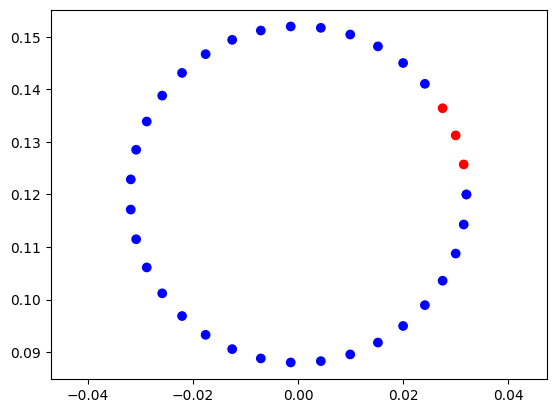

In [1032]:
points = [point_on_circle(phi) for phi in np.linspace(0, 2*np.pi, 36)]
cols = ['red'] * 4 + ['blue'] * 32
plt.scatter([p[1] for p in points], [p[2] for p in points], c=cols)
plt.axis('equal')
plt.show()

In [1033]:
def inv_kinematics(x,y,z,phi, dh_conv):
    """
    Hardcoded inverse kinematics for the robot arm
    """
    
    theta1 = atan2(y, x)
    
    a2 = dh_conv[2]['a']
    a3 = dh_conv[3]['a']
    a4 = dh_conv[4]['a']
    
    d1 = dh_conv[1]['d']
    
    r = sqrt(x**2 + y**2)
    r2 = cos(phi)*a4
    
    #Given r = r1 + r2
    r1 = r - r2
    
    z1 = d1
    z3 = sin(phi)*a4
    
    #Given z = z1 + z2 + z3
    z2 = z - z1 - z3
    
    c23 = sqrt(z2**2 + r1**2)
    
    c3 = ((c23**2) - (a2**2) - (a3**2)) / (2*a2*a3)
    
    
    D = (c23**2 - a2**2 - a3**2)/(-2*a2*a3)
    theta3 = -(atan2(sqrt(1-D**2), D) - pi)

    
    # #two solutions for theta3
    # print("c3", c3)
    
    # theta3_1 = atan2(-sqrt(1 - c3**2), c3)
    # theta3_2 = atan2(sqrt(1 - c3**2), c3)
    
    
    # print("theta3_1", theta3_1)
    # print("theta3_2", theta3_2)
    
    # theta3 = theta3_1
    
    theta2 = atan2(z2, r1) - atan2(a3*sin(theta3), a2 + a3*cos(theta3))
    
    theta4 = phi - theta2 - theta3
    
    
    return theta1, theta2, theta3, theta4

inv_kinematics(-0.032,0.15, 0.12, 0, dh_conv)


(-1.36061374013273 + pi,
 -0.239730216951784,
 -1.47169003299079 + pi,
 1.71142024994257 - pi)

In [1034]:
# def inv_kinematics(x,y,z,phi,dh_conv):
#     """ """
#     a1,a2,a3,a4 = 50/1000, 93/1000, 93/1000, 50/1000# mm

#     theta1 = atan2(y, x)

#     r = sqrt(x*x + y*y)
#     r2 = a4 * cos(phi)
#     r1 = r - r2

#     d1 = a1
#     d3 = a4*sin(phi)
#     d2 = z - d1 - d3

#     C23 = sqrt(r1*r1 + d2*d2)

#     # Elbow down
#     # theta3 = -acos((a2*a2 + a3*a3 - C23*C23) / (2*a2*a3)) + pi

#     # Elbow up - not minus in front of sqrt()
#     D = (C23*C23 - a2*a2 - a3*a3) / (-2*a2*a3)
#     theta3 = -(atan2(-sqrt(1 - D*D), D) - pi)

#     theta2 = atan2(d2, r1) - atan2(a3*sin(theta3), a2+a3*cos(theta3))
#     theta4 = phi - theta2 - theta3
    
#     return theta1.evalf(), theta2.evalf(), theta3.evalf(), theta4.evalf()

In [1035]:

def jacobian_point(J, _theta_1, _theta_2, _theta_3, _theta_4):
    """Computes jacobian given joint angles"""
    res = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), J, 'sympy')
    return res(_theta_1, _theta_2, _theta_3, _theta_4)

def jacobian_circle_angle(J, phi, end_angle, dh_conv):
    """Computes jacobian given an angle of a circle"""
    
    point_on_circle(phi) #Compute coordinates of point on circle
    
    #Compute angles of joints
    _theta_1, _theta_2, _theta_3, _theta_4 = inv_kinematics(*point_on_circle(phi), end_angle, dh_conv)
    

    #Compute jacobian
    return jacobian_point(J, _theta_1, _theta_2, _theta_3, _theta_4)


In [1036]:
J_end = jacobian(list(T.values())[:5], list(dh_conv.values())[:4])
J_end

# r1 = jacobian_circle_angle(J_end, 0)
# r2 = jacobian_circle_angle(J_end, pi/2)
r3 = jacobian_circle_angle(J_end, pi, 0, dh_conv)
# r4 = jacobian_circle_angle(J_end, 3*pi / 2)

# print(np.array(r1))
# print(np.array(r2))
# print((r3))
# print(np.array(r4))
r3

Matrix([
[0.032, -0.0684594985497015, -0.0900555097184086,                  0],
[ 0.15,  0.0146046930239363,  0.0192118420732605,                  0],
[    0,   0.153375356560303,  0.0630349642695982,               0.05],
[    0,  -0.208638471770519,  -0.208638471770519, -0.208638471770519],
[    0,  -0.977992836424308,  -0.977992836424308, -0.977992836424308],
[    1,                   0,                   0,                  0]])

In [1037]:
J_cam = jacobian(list(T.values())[:6], list(dh_conv.values())[:5])
J_cam

ROUNDING_FACTOR = 3

r1 = jacobian_circle_angle(J_cam, 0, 0, dh_conv)
r2 = jacobian_circle_angle(J_cam, pi/2, 0, dh_conv)
r3 = jacobian_circle_angle(J_cam, pi, 0, dh_conv)
r4 = jacobian_circle_angle(J_cam, 3*pi / 2, 0, dh_conv)

print(np.round(np.array(r1).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r2).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r3).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r4).astype(np.float64), ROUNDING_FACTOR))

[[-0.077 -0.068 -0.09   0.     0.209]
 [ 0.135 -0.015 -0.019  0.    -0.978]
 [ 0.     0.148  0.058  0.045  0.   ]
 [ 0.     0.209  0.209  0.209  0.   ]
 [ 0.    -0.978 -0.978 -0.978  0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.045 -0.102 -0.093  0.     0.   ]
 [ 0.135  0.     0.     0.    -1.   ]
 [ 0.     0.135  0.042  0.035  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -1.    -1.    -1.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.013 -0.068 -0.09   0.    -0.209]
 [ 0.135  0.015  0.019  0.    -0.978]
 [ 0.     0.129  0.039  0.026  0.   ]
 [ 0.    -0.209 -0.209 -0.209  0.   ]
 [ 0.    -0.978 -0.978 -0.978  0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.045 -0.038 -0.09   0.     0.   ]
 [ 0.135  0.     0.     0.    -1.   ]
 [ 0.     0.135  0.058  0.035  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -1.    -1.    -1.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]


In [1038]:
J_cam = jacobian(list(T.values())[:6], list(dh_conv.values())[:5])
J_cam

r1 = jacobian_circle_angle(J_cam, 0, 0, dh_conv)
r2 = jacobian_circle_angle(J_cam, pi/2, 0, dh_conv)
r3 = jacobian_circle_angle(J_cam, pi, 0, dh_conv)
r4 = jacobian_circle_angle(J_cam, 3*pi / 2, 0, dh_conv)

print(np.round(np.array(r1).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r2).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r3).astype(np.float64), ROUNDING_FACTOR))
print(np.round(np.array(r4).astype(np.float64), ROUNDING_FACTOR))

[[-0.077 -0.068 -0.09   0.     0.209]
 [ 0.135 -0.015 -0.019  0.    -0.978]
 [ 0.     0.148  0.058  0.045  0.   ]
 [ 0.     0.209  0.209  0.209  0.   ]
 [ 0.    -0.978 -0.978 -0.978  0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.045 -0.102 -0.093  0.     0.   ]
 [ 0.135  0.     0.     0.    -1.   ]
 [ 0.     0.135  0.042  0.035  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -1.    -1.    -1.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.013 -0.068 -0.09   0.    -0.209]
 [ 0.135  0.015  0.019  0.    -0.978]
 [ 0.     0.129  0.039  0.026  0.   ]
 [ 0.    -0.209 -0.209 -0.209  0.   ]
 [ 0.    -0.978 -0.978 -0.978  0.   ]
 [ 1.     0.     0.     0.     0.   ]]
[[-0.045 -0.038 -0.09   0.     0.   ]
 [ 0.135  0.     0.     0.    -1.   ]
 [ 0.     0.135  0.058  0.035  0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.    -1.    -1.    -1.     0.   ]
 [ 1.     0.     0.     0.     0.   ]]


## Problem 5

In [1112]:
def temporal_rate(R, w) -> np.ndarray:
    x_dot = np.array([
        [R[2,0] * w[1] - R[1,0] * w[2], R[2,1] * w[1] - R[1,1] * w[2], R[2,2] * w[1] - R[1,2] * w[2]],
        [R[0,0] * w[2] - R[2,0] * w[0], R[0,1] * w[2] - R[2,1] * w[0], R[0,2] * w[2] - R[2,2] * w[0]],
        [R[1,0] * w[0] - R[0,0] * w[1], R[1,1] * w[0] - R[0,1] * w[1], R[1,2] * w[0] - R[0,2] * w[1]],
    ])
    return x_dot

def joint_velocity(J, phi, velocity, end_angle, dh_conv):
    M = jacobian_circle_angle(J, phi, end_angle, dh_conv)[0:3, :] 

    N = (M.H * M) ** -1 * M.H
    
    q = N * velocity
    
    
    
    return q
    

In [ ]:
joint_velocity(J_end,pi/2, )

## Problem 6

In [1040]:
def interpolation_polynomial(dh_conv, start_angle, end_angle, t_in, t_end, start_vel, end_vel):
    """Computes polynomial interpolation"""
    point_start = point_on_circle(start_angle)
    point_end = point_on_circle(end_angle)
    q_in = inv_kinematics(*point_start, 0, dh_conv)
    q_end = inv_kinematics(*point_end, 0, dh_conv)
    
    A_list = []
    points = []
    # print(t_in, t_end)
    for i in range(4):
        b = Matrix([q_in[i], start_vel[i], 0, q_end[i], end_vel[i], 0])
        
        M = Matrix([
            [1, t_in, t_in**2, t_in**3, t_in**4, t_in**5],
            [0, 1, 2*t_in, 3*t_in**2, 4*t_in**3, 5*t_in**4],
            [0, 0, 2, 6*t_in, 12*t_in**2, 20*t_in**3],
            [1, t_end, t_end**2, t_end**3, t_end**4, t_end**5],
            [0, 1, 2*t_end, 3*t_end**2, 4*t_end**3, 5*t_end**4],
            [0, 0, 2, 6*t_end, 12*t_end**2, 20*t_end**3]
        ])

        M_inv = M.inv()

        A = M_inv * b
        
        A_list.append(A)
        points.append(point_start)
        
        
    return A_list, points

In [1041]:
np.linspace(0, 2*np.pi, 5)


array([0.        , 1.57079633, 3.14159265, 4.71238898, 6.28318531])

In [1058]:
def calc_segments(dh_conv, J_end, n_points, velocities, total_time = 8):
    """Computes the joint angles for a given number of points"""
    
    segments = []
    times = []
    
    
    angles = np.linspace(0, 2*np.pi, n_points)
    
    points = []
    
    _joint_velocity = []
    for phi, vel in zip(angles, velocities):
        _joint_velocity.append(joint_velocity(J_end, phi, vel, 0, dh_conv))
        
    
    for i in range(len(angles) - 1):
        
        
        
        start_angle = angles[i]
        end_angle = angles[i + 1]
        
        _start_vel = _joint_velocity[i]
        _end_vel = _joint_velocity[i + 1]
        
        t_start = 0
        t_end = total_time / (n_points-1)
        
        seq, seq_points = interpolation_polynomial(dh_conv, start_angle, end_angle, t_start, t_end, _start_vel, _end_vel)
        segments.append(seq)
        
        points.extend(seq_points)
        times.append(t_end)    
        
    return segments, np.array(points), times, _joint_velocity

In [1043]:
def angular_velocity(phi, velocity):
    ang_vel = Matrix([0, cos(phi+pi/2) * velocity, sin(phi+pi/2) * velocity])
    ang_vel_size = ang_vel[0]**2 + ang_vel[1]**2 + ang_vel[2]**2
    if ang_vel[0] != 0:
        print("get fucked")
    assert round(float(ang_vel_size),8) == round(float(velocity**2),8)
    return ang_vel

In [1084]:
N_POINTS = 9


velocities = [Matrix([0,0,0])] + [angular_velocity(phi, 27/1000) for phi in np.linspace(0, float(2*pi), N_POINTS)][1:-1] + [Matrix([0,0,0])]
_segments, _points, times, _joint_velocity = calc_segments(dh_conv, J_end, N_POINTS, velocities)
np.array(_joint_velocity).shape

(9, 4, 1)

In [1085]:
points = []
jacobian_paths = []
for index, segment_i in enumerate(_segments):
    times_i = np.linspace(0, times[index], 100)
    for t_i in times_i:
        T_i = Matrix([1, t_i, t_i**2, t_i**3, t_i**4, t_i**5]).T

        Q_a = Matrix([ T_i @ seq_i for seq_i in segment_i])
        Q_a

        _theta_1, _theta_2, _theta_3, _theta_4 = Q_a

        jacobian_paths.append(jacobian_point(J_end,_theta_1, _theta_2, _theta_3, _theta_4))

        transform_matrix = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), T['04'], 'sympy')

        transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4)

        origin = np.array([0, 0, 0, 1])

        joint_position = transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4) @ origin

        points.append(joint_position[:3])
print(joint_position.shape)
points = np.array(points).astype(np.float64)

(4,)


In [1086]:
x, y, z = points[:, 0], points[:, 1], points[:, 2]

In [1087]:
xp, yp, zp = _points[:,0],_points[:,1],_points[:,2]

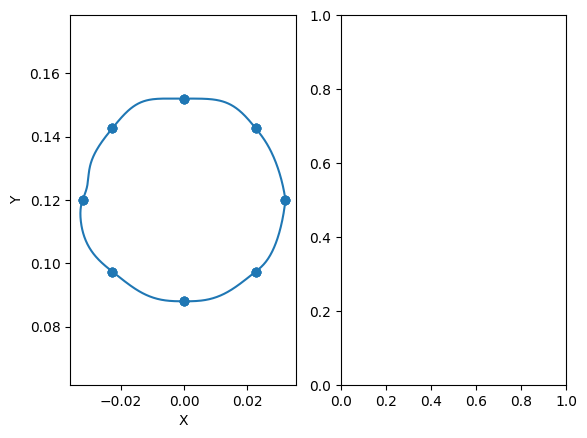

In [1088]:
fig, axs = plt.subplots(1, 2)
axs[0].scatter(yp,zp)
axs[0].plot(y,z)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].axis('equal')
plt.show()

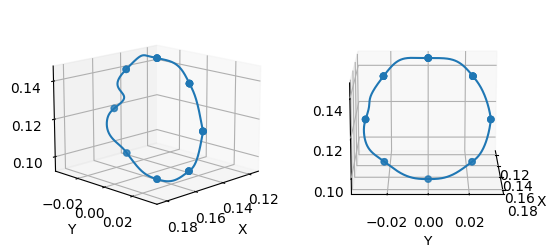

In [1089]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
# cols = ['red'] + ['green'] * (len(points)-2) + ['blue']
axs[0].scatter(xp, yp, zp)
# axs[0].scatter(y, z, c = cols)
axs[0].plot(x, y,z)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
axs[0].axis('equal')
axs[0].view_init(elev=15, azim=45, roll=0)
axs[1].scatter(xp, yp,zp)
axs[1].plot(x, y,z)
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')
axs[1].axis('equal')
axs[1].view_init(elev=15, azim=0, roll=0)
plt.show()

In [1074]:
points = []

for phi in np.linspace(0, 2*np.pi, 36):
    _theta_1, _theta_2, _theta_3, _theta_4 = inv_kinematics(*point_on_circle(phi), 0, dh_conv)


    transform_matrix = sympy.lambdify((theta_1, theta_2, theta_3, theta_4), T['04'], 'sympy')

    transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4)

    origin = np.array([0, 0, 0, 1])

    joint_position = transform_matrix(_theta_1, _theta_2, _theta_3, _theta_4) @ origin

    points.append(joint_position[:3])
    
points = np.array(points).astype(np.float64)

In [1075]:
x, y, z = points[:, 0], points[:, 1], points[:, 2]

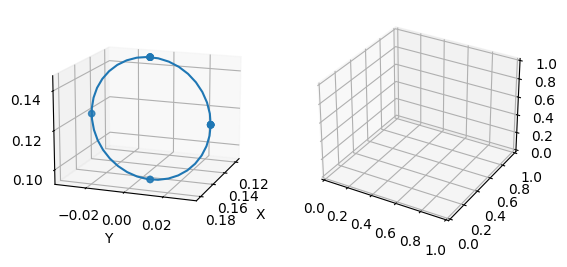

In [1077]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
# cols = ['red'] + ['green'] * (len(points)-2) + ['blue']
axs[0].scatter(xp, yp, zp)
# axs[0].scatter(y, z, c = cols)
axs[0].plot(x, y, z)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')
axs[0].set_zlabel('Z')
axs[0].axis('equal')
axs[0].view_init(elev=15, azim=20, roll=0)
plt.show()

## Problem 8

In [1096]:
angles = np.linspace(0, 2*np.pi, 36)
conditions = [np.linalg.cond(np.array(jacobian_circle_angle(J_end, phi, 0, dh_conv)).astype(np.float64)) for phi in angles]


In [1104]:
max_cond_index = np.argmax(conditions)
max_cond_angle = angles[max_cond_index]
np.linalg.matrix_rank( np.array(jacobian_circle_angle(J_end, max_cond_angle, 0, dh_conv)).astype(np.float64))

4

In [1105]:
angles = np.linspace(0, 2*np.pi, 800)
conditions = [np.linalg.cond(np.array(J_path).astype(np.float64)) for J_path in jacobian_paths]

In [1106]:
max_cond_index = np.argmax(conditions)
max_cond_angle = angles[max_cond_index]
np.linalg.matrix_rank( np.array(jacobian_circle_angle(J_end, max_cond_angle, 0, dh_conv)).astype(np.float64))

4

Text(0.5, 1.0, 'Condition of Jacobian along interpolated path')

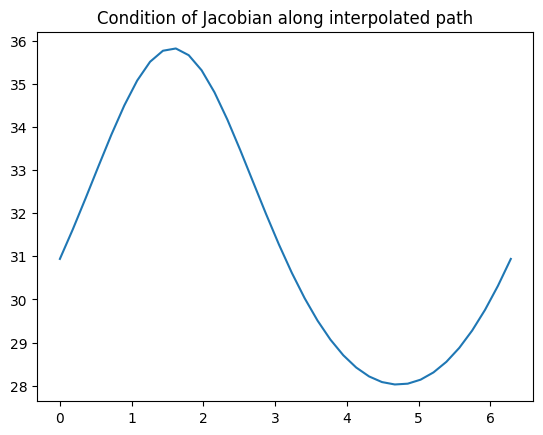

In [1097]:
plt.plot(angles,conditions)
plt.title("Condition of Jacobian along interpolated path")

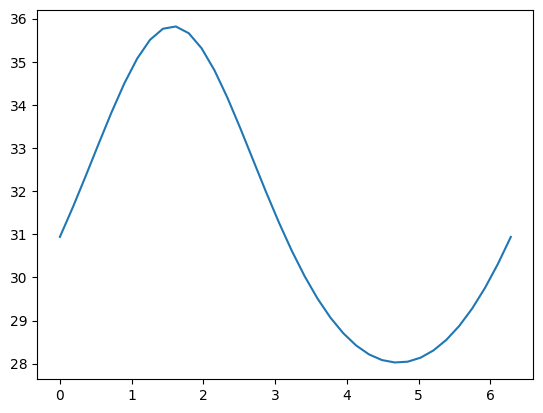

In [1083]:
plt.plot(angles,conditions)

## Problem 9

In [874]:

def joint_velocity(J, phi, velocity, end_angle, dh_conv):
    M = jacobian_circle_angle(J_end, phi, end_angle, dh_conv)[0:3, :] 

    N = (M.H * M) ** -1 * M.H
    
    q = N * velocity
    
    
    
    return q
    

In [1107]:
F = np.array([0,0,-1,0,0,0])

taus = []
for J_path in jacobian_paths:
    #J_path_pinv = np.linalg.pinv(np.array(J_path,dtype="float64"))
    taus.append(J_path.T@F)


taus = np.array(taus)

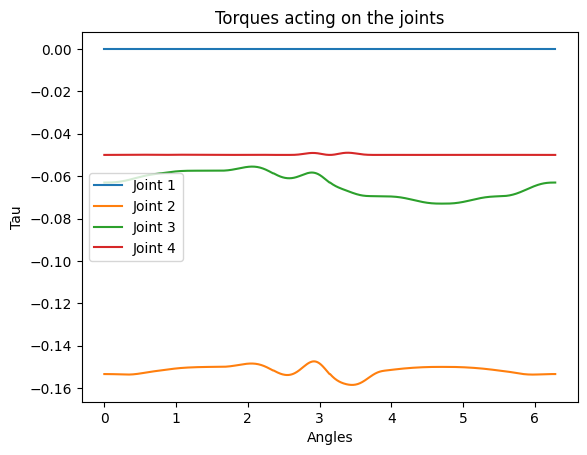

In [1111]:
plt.plot(angles, taus[:, 0], label="Joint 1")
plt.plot(angles, taus[:, 1], label="Joint 2")
plt.plot(angles, taus[:, 2], label="Joint 3")
plt.plot(angles, taus[:, 3], label="Joint 4")

# Add a legend to the plot
plt.legend()

# Optionally add labels and title
plt.xlabel("Angles")
plt.ylabel("Tau")
plt.title("Torques acting on the joints")

# Show the plot
plt.show()


## Problem 10

In [1004]:
np.array(velocities).shape

(5, 3, 1)

In [1063]:
# Define DH parameters
from sympy import symbols, cos, sin, Matrix, pi, eye, zeros
theta_1, theta_2, theta_3, theta_4 = symbols('theta_1 theta_2 theta_3 theta_4')
d1 = 50/1000
a2 = 93/1000
a3 = 93/1000
a4 = 50/1000

# Transformation matrices using DH parameters
def A_dh(theta, d, a, alpha):
    return Matrix([
        [cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
        [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
        [0, sin(alpha), cos(alpha), d],
        [0, 0, 0, 1]
    ])

# DH parameters in radians
A01 = A_dh(theta_1, d1, 0, pi/2)
A12 = A_dh(theta_2, 0, a2, 0)
A23 = A_dh(theta_3, 0, a3, 0)
A34 = A_dh(theta_4, 0, a4, 0)

# Compute cumulative transformation matrices
T_0_1 = A01
T_0_2 = T_0_1 * A12
T_0_3 = T_0_2 * A23
T_0_4 = T_0_3 * A34

# Center of mass positions in their respective frames
T_1_CM1 = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, d1/2],
    [0, 0, 0, 1]
])

T_2_CM2 = Matrix([
    [1, 0, 0, a2/2],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

T_3_CM3 = Matrix([
    [1, 0, 0, a3/2],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

T_4_CM4 = Matrix([
    [1, 0, 0, a4/2],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Compute transformation matrices to center of mass
T_0_CM1 = T_0_1 * T_1_CM1
T_0_CM2 = T_0_2 * T_2_CM2
T_0_CM3 = T_0_3 * T_3_CM3
T_0_CM4 = T_0_4 * T_4_CM4


In [1064]:
def compute_jacobian(T_list, o_CM, n_joints=4):
    # Initialize variables
    J_v = []
    J_w = []
    z_prev = Matrix([0, 0, 1])  # z0 axis
    o_prev = Matrix([0, 0, 0])  # origin of frame {0}
    
    for i in range(n_joints):
        if i < len(T_list):
            T_i = T_list[i]
            R_i = T_i[:3, :3]
            o_i = T_i[:3, 3]
            z_i = R_i[:, 2]
        else:
            # If beyond the provided transformations, use identity
            z_i = z_prev
            o_i = o_prev
        
        # Compute J_v_i and J_w_i
        J_v_i = z_prev.cross(o_CM - o_prev)
        J_w_i = z_prev
        
        J_v.append(J_v_i)
        J_w.append(J_w_i)
        
        # Update for next iteration
        z_prev = z_i
        o_prev = o_i
    
    # Stack columns to form matrices
    J_v = Matrix.hstack(*J_v)
    J_w = Matrix.hstack(*J_w)
    return J_v, J_w

# Compute Jacobians for each link
J_v_1, J_w_1 = compute_jacobian([eye(4), T_0_1], T_0_CM1[:3, 3])
J_v_2, J_w_2 = compute_jacobian([eye(4), T_0_1, T_0_2], T_0_CM2[:3, 3])
J_v_3, J_w_3 = compute_jacobian([eye(4), T_0_1, T_0_2, T_0_3], T_0_CM3[:3, 3])
J_v_4, J_w_4 = compute_jacobian([eye(4), T_0_1, T_0_2, T_0_3, T_0_4], T_0_CM4[:3, 3])


In [1065]:
# Define masses and inertia matrices
I0_value = 1.76e-5
m1 = 0.06
m2 = m3 = 0.08
m4 = 0.04

I1 = Matrix([
    [I0_value, 0, 0],
    [0, 0.5*I0_value, 0],
    [0, 0, 0.9*I0_value]
])

I2 = I3 = Matrix([
    [0.45*I0_value, 0, 0],
    [0, 1.4*I0_value, 0],
    [0, 0, 1.2*I0_value]
])

I4 = Matrix([
    [0.5*I0_value, 0, 0],
    [0, 0.5*I0_value, 0],
    [0, 0, 0.5*I0_value]
])

# Rotation matrices to centers of mass
R1 = T_0_CM1[:3, :3]
R2 = T_0_CM2[:3, :3]
R3 = T_0_CM3[:3, :3]
R4 = T_0_CM4[:3, :3]

# Compute D(q)
D = (m1 * J_v_1.T * J_v_1 + J_w_1.T * R1 * I1 * R1.T * J_w_1 +
     m2 * J_v_2.T * J_v_2 + J_w_2.T * R2 * I2 * R2.T * J_w_2 +
     m3 * J_v_3.T * J_v_3 + J_w_3.T * R3 * I3 * R3.T * J_w_3 +
     m4 * J_v_4.T * J_v_4 + J_w_4.T * R4 * I4 * R4.T * J_w_4)


In [1066]:
# Gravity vector
g_vec = Matrix([0, 0, -9.81])

# Potential energy
P = m1 * g_vec.dot(T_0_CM1[:3, 3]) + m2 * g_vec.dot(T_0_CM2[:3, 3]) + \
    m3 * g_vec.dot(T_0_CM3[:3, 3]) + m4 * g_vec.dot(T_0_CM4[:3, 3])

# Compute g(q)
g_q = Matrix([P.diff(theta_1), P.diff(theta_2), P.diff(theta_3), P.diff(theta_4)])


In [1067]:
# Assuming you have the coefficients A_list for each segment
q_t_list = []
q_dot_t_list = []
q_ddot_t_list = []
time_steps = []

for index, segment_i in enumerate(_segments):
    times_i = np.linspace(0, times[index], 100)  # 100 points per segment
    for t_i in times_i:
        # Construct the time vector for position, velocity, and acceleration
        T_pos = Matrix([1, t_i, t_i**2, t_i**3, t_i**4, t_i**5])
        T_vel = Matrix([0, 1, 2*t_i, 3*t_i**2, 4*t_i**3, 5*t_i**4])
        T_acc = Matrix([0, 0, 2, 6*t_i, 12*t_i**2, 20*t_i**3])
        
        # Compute q_t, q_dot_t, q_ddot_t for each joint
        q_t = []
        q_dot_t = []
        q_ddot_t = []
        for A in segment_i:
            q_t.append((T_pos.T * A)[0])
            q_dot_t.append((T_vel.T * A)[0])
            q_ddot_t.append((T_acc.T * A)[0])
        
        q_t_list.append(q_t)
        q_dot_t_list.append(q_dot_t)
        q_ddot_t_list.append(q_ddot_t)
        time_steps.append(t_i + sum(times[:index]))  # Accumulate time across segments

# Initialize lists to store tau values
tau_list = []

for q_t, q_dot_t, q_ddot_t in zip(q_t_list, q_dot_t_list, q_ddot_t_list):
    # Substitute q_t into D(q), g(q)
    D_num = D.subs({
        theta_1: q_t[0],
        theta_2: q_t[1],
        theta_3: q_t[2],
        theta_4: q_t[3]
    })
    g_q_num = g_q.subs({
        theta_1: q_t[0],
        theta_2: q_t[1],
        theta_3: q_t[2],
        theta_4: q_t[3]
    })
    # Convert to numerical values
    D_num = D_num.evalf()
    g_q_num = g_q_num.evalf()
    # Compute tau
    tau = D_num * Matrix(q_ddot_t) + g_q_num
    tau_list.append(tau)


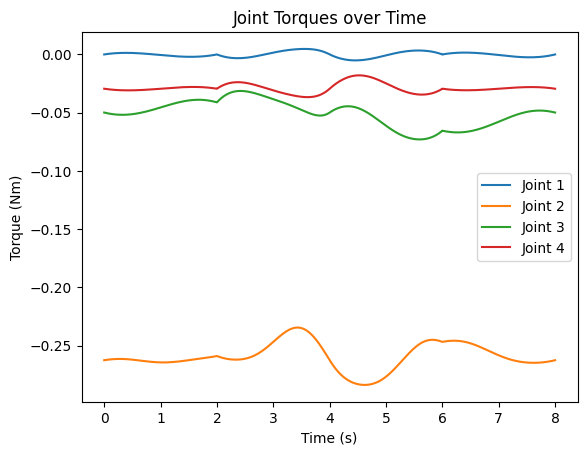

In [1068]:
import matplotlib.pyplot as plt

tau_array = np.array([np.array(tau).astype(np.float64).flatten() for tau in tau_list])
time_array = np.array(time_steps)

plt.figure()
for i in range(4):
    plt.plot(time_array, tau_array[:, i], label=f'Joint {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Joint Torques over Time')
plt.legend()
plt.show()
